<a href="https://colab.research.google.com/github/janaat22/NLP_seq2seq/blob/master/seq2seq_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# Sequence to Sequence Models (COSC 6336)

<br>
<div style="text-align: right; font-size: large;"><i>Submitted by Janaat</i></div>
<div style="text-align: right; font-size: small;"><i>April 10, 2020</i></div>
<br>
<div style="text-align: right; font-size: small;"><i>model built on top of the original model authored by Gustavo Aguilar</i></div>

---

In this notebook, we show a minimalistic implementation of sequence to sequence (seq2seq) models. We use LSTM-based encoder and decoder, and we optimize the model on a toy dataset from automatically-generated data. The high-level view of the model is shown in the image below:

<img src='https://github.com/gaguilar/basic_nlp_tutorial/blob/master/tutorial_on_seq2seq_models/images/encoder-decoder.png?raw=1' width='70%'/>

Then, we improve our model using an attention-based decoder.

Here's what we cover in this notebook:
1. Define a simple (auto-generated) dataset
2. Define the encoder 
3. Define the decoder 
4. Train the model
5. Evaluate and inspect the predictions
6. Compare with seq2seq with attention


In [0]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm

torch.manual_seed(1)
random.seed(1)

# Dataset Description

Our automatically-generated data will contain sequences with repeated and unordered letters. Such sequences must be mapped to alphabetically-sorted sequences of unique letters. Here are a few examples:
```
ccccaaabb        ->   abc
vvvrxduuu        ->   druvx
sddvvvzzuuuxxx   ->   dsuvxz
```


In [0]:
def sorting_letters_dataset(size):
    dataset = []
    for _ in range(size):
        x = []
        for _ in range(random.randint(3, 10)):
            letter = chr(random.randint(97, 122))
            repeat = [letter] * random.randint(1, 3)
            x.extend(repeat)
        y = sorted(set(x))
        dataset.append((x, y))
    return zip(*dataset)

# Vocabulary

We will have two splits in our data, one for **training**, and another for validation. The training set will be **20,000** samples and we will use this set to update the parameters of the model. The **validation** set will be **5,000** samples, which we use to select the best model.

_**NOTE**: The validation set is never used to update the parameters of the model. Instead, we use it to make sure that the model is generalizing well, and not doing overfitting._

In [0]:
class Vocab:
    def __init__(self, vocab):
        self.itos = vocab
        self.stoi = {d:i for i, d in enumerate(self.itos)}
        
    def __len__(self):
        return len(self.itos) 
    
src_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)])
tgt_vocab = Vocab(['<pad>'] + [chr(i+97) for i in range(26)] + ['<start>', '<stop>'] )

train_inp, train_out = sorting_letters_dataset(20_000)
valid_inp, valid_out = sorting_letters_dataset(5_000)

# Embedding
Now, we need to map the text data into numeric values. These numeric values are indexes that correspond to the entries in the embedding lookup table. 

Since we do batch training, it is convenient to have each input sample in a fixed length. So we get the maximun sample length from the generated dataset and make every sample length to match that length using padding.

In [0]:
START_IX = tgt_vocab.stoi['<start>']
STOP_IX  = tgt_vocab.stoi['<stop>']

def find_seq_len(elems):
  maxlen = max([len(i) for i in elems])
  minlen = min([len(i) for i in elems])
  # return round((maxlen + minlen)/2)
  return maxlen


def map_elems(elems, mapper, pad_index, SEQ_LENGTH ):
    assert len(elems) <= SEQ_LENGTH, ("Invalid string: %s" % str(many_elems))

    return [mapper[elem] for elem in elems] + ([pad_index] * (SEQ_LENGTH - len(elems)))

def map_many_elems(many_elems, mapper, pad_index,SEQ_LENGTH ):
    return [map_elems(elems, mapper, pad_index, SEQ_LENGTH) for elems in many_elems]

MAX_INPUT_LENGTH = find_seq_len(train_inp)
MAX_OUTPUT_LENGTH = find_seq_len(train_out)

print('Max Input Length:', MAX_INPUT_LENGTH)
print('Max Output Length:', MAX_OUTPUT_LENGTH)

train_x = map_many_elems(train_inp, src_vocab.stoi, src_vocab.stoi['<pad>'],MAX_INPUT_LENGTH )
train_y = map_many_elems(train_out, tgt_vocab.stoi, tgt_vocab.stoi['<stop>'], MAX_OUTPUT_LENGTH)

valid_x = map_many_elems(valid_inp, src_vocab.stoi, src_vocab.stoi['<pad>'], MAX_INPUT_LENGTH)
valid_y = map_many_elems(valid_out, tgt_vocab.stoi, tgt_vocab.stoi['<stop>'], MAX_OUTPUT_LENGTH)

Max Input Length: 28
Max Output Length: 10


## 2. Encoder

Our encoder will be a simple LSTM model with one layer and one direction.

The encoder takes the following arguments:
<ul>
<li>input_dim is the size/dimensionality of the vectors that will be input to the encoder. This is equal to the input vocabulary size.

<li>emb_dim is the dimensionality of the embedding layer. This layer converts the input vectors into dense vectors with emb_dim dimensions.

<li>lstm_size is the dimensionality of the hidden and cell states.

<li>dropout is the amount of dropout to use. This is a regularization parameter to prevent overfitting. 
</ul>

# Batch processing of inputs in the Encoder

In the forward method, we pass in the source sentence, $X$, which is converted into dense vectors using the embedding layer, and then dropout is applied. These embeddings are then passed into the LSTM.

The LSTM returns: outputs (the top-layer hidden state for each time-step), hidden (the final hidden state for each layer, $h_n$, stacked on top of each other) and cell (the final cell state for each layer, $c_n$, stacked on top of each other).

<img src='https://github.com/gaguilar/basic_nlp_tutorial/blob/master/tutorial_on_seq2seq_models/images/encoder.png?raw=1' width='50%'/>

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, z_type, dropout=0.5):
        super(Encoder, self).__init__()
        self.z_index = z_type
        
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, lstm_size, batch_first=True)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, inputs):
        device = next(self.parameters()).device
        seq = torch.tensor(inputs).to(device) # (1, seqlen)
        emb = self.emb(seq) # (1, seqlen, emb_dim)
        batch_size = seq.size(0)
        # maxlen = seq.size(1)
        # print('batch 0' + str(batch_size))
        # print('batch 1' + str(maxlen))
        # print('Batch Size: %s x %s' % (seq.shape))
        # print('Emb Size 0:' + str(emb.size(0)))
        # print('Emb Size 1:' + str(emb.size(1)))
        emb = self.drop(emb) 
        
        outs, (h_n, c_n) = self.lstm(emb)

        assert outs.size(0) == batch_size
        #Jan
        if self.z_index == 1:
            return h_n[0], c_n[0] # (seqlen, lstm_dim)
        else:
            return outs # (1, seqlen, lstm_dim)

encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size=128, z_type=1)
encoder

Encoder(
  (emb): Embedding(27, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
)

## 3. Decoder

Similar to the encoder, the decoder will be a LSTM cell with one layer and one direction. 

The arguments and initialization of the decoder are are similar to the Encoder class. There is one addition of the Linear layer, used to make the predictions from the top layer hidden state.

As we are only decoding one token at a time, the input tokens will always have a sequence length of 1. And so we use the nn.LSTMCell.


# Batch processing of inputs in the Decoder
Similar to the encoder, we pass through an <i>embedding layer</i> and apply <i>dropout</i>. 
<ul>
<li>This batch of embedded tokens is then passed into the LSTM with the previous hidden and cell states. This produces an output (hidden state from the top layer of the LSTM), a new hidden state (one for each layer, stacked on top of each other) and a new cell state (also one per layer, stacked on top of each other). 
<li>We then pass the output through the linear layer to receive our prediction. 
<li>We then return the prediction, the new hidden state and the new cell state.
<ul>

<img src='https://github.com/gaguilar/basic_nlp_tutorial/blob/master/tutorial_on_seq2seq_models/images/decoder.png?raw=1' width='50%'/>

In [0]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, dropout=0.5):
        super(Decoder, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTMCell(emb_dim, lstm_size)
        self.clf = nn.Linear(lstm_size, vocab_size)        
        self.drop = nn.Dropout(dropout)
        self.objective = nn.CrossEntropyLoss(reduction="sum")
        
    def forward(self, state, targets, curr_token, last_token):
        device = next(self.parameters()).device
        
        loss = 0
        shifted = [t + [last_token] for t in targets]
        batch_size = state[0].shape[0]
        target_len = len(targets[0]) + 1
        curr_tokens = [curr_token] * batch_size

        for i in range(target_len):
            inp = torch.tensor(curr_tokens).to(device)            
            emb = self.emb(inp)
            # print(emb)
            emb = self.drop(emb)
            
            state = self.lstm(emb, state)
            q_i, _ = state 
            q_i = self.drop(q_i)

            scores = self.clf(q_i)
            # print("decoder shifted")
            # print(shifted)
            outs = [t[i] for t in shifted]
            
            target = torch.tensor(outs).to(device)
            loss += self.objective(scores, target)   
            curr_tokens = outs

        return loss / target_len

    def predict(self, state, curr_token, last_token, maxlen=15):
        device = next(self.parameters()).device
        batch_size = state[0].shape[0]
        preds = []
        
        for i in range(maxlen):
            inp = torch.tensor([curr_token]).to(device)
            emb = self.emb(inp)
            
            state = self.lstm(emb, state)
            h_i, _ = state
            
            scores = self.clf(h_i)
            pred = torch.argmax(torch.softmax(scores, dim=1))
            curr_token = pred
            
            if last_token == pred:
                break
            preds.append(pred)
        return preds
    
decoder = Decoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size=128)
decoder

Decoder(
  (emb): Embedding(29, 64)
  (lstm): LSTMCell(64, 128)
  (clf): Linear(in_features=128, out_features=29, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (objective): CrossEntropyLoss()
)

### Decoder LSTM with attention

The attention version that we use for this implementation is Luong's attention, also known as multiplicative attention. 

Consider the encoder outputs $h = [h_1, h_2, \dots, h_n]$, and the query vector $q_j$ of the decoding time step $j$ as the hidden vector of the decoder LSTM, then we define multiplicative attention as follows:

$$
\begin{align}
u_i &= v^\intercal tanh(W [h_i + q_j]) \\
\alpha_i &= \frac{exp(u_i)}{\sum^N_k exp(u_k)} \\
c &= \sum^N_i \alpha_i h_i
\end{align}
$$
<ul>

<li>Encoder produces hidden states of each element in the input sequence

<li>The previous decoder hidden state and decoder output is passed through the Decoder LSTM to generate a new hidden state for that time step

<li>Using the new decoder hidden state and the encoder hidden states scores are calculated

<li>The alignment scores for each encoder hidden state are combined and represented in a single vector and subsequently softmaxed

<li>The encoder hidden states and their respective alignment scores are multiplied to form the context vector

<li>The context vector is concatenated with the decoder hidden state generated in step 2 as passed through a fully connected layer to produce a new output

</ul>
The implementation is as follows:

In [0]:
class Attention(nn.Module):
    def __init__(self, input_dim, attn_dim):
        super(Attention, self).__init__()
        self.W = nn.Linear(input_dim, attn_dim)
        self.v = nn.Linear(attn_dim, 1, bias=False)
        
    def forward(self, dec_hidden, enc_outs):
        
        seqlen = enc_outs.size(1)
        
        repeat_h = dec_hidden.unsqueeze(1)  # make room to repeat on seqlen dim

        repeat_h = repeat_h.repeat(1, seqlen, 1)  # (1, seqlen, hidden)
       
        concat_h = torch.cat((enc_outs, repeat_h), dim=2) # (1, seqlen, hidden*2)
        
        scores = self.v(torch.tanh(self.W(concat_h))) # (1, seqlen, 1)
        
        probs = torch.softmax(scores, dim=1)
        # print('probs ::')
        # print(probs.shape)
        # print('enc out ::')
        # print(enc_outs.shape)
        weighted = enc_outs * probs # (1, seqlen, hidden)
        
        context = torch.sum(weighted, dim=1, keepdim=False) # (1, hidden)
        # print('context::')
        # print(context.shape)
        # print('dec_ hidden::')
        # print(dec_hidden.shape)
        combined = torch.cat((dec_hidden, context), dim=1)  # (1, hidden*2)
        
        return combined

Since we want the decoder to focus on the right hidden outputs of the encoder, we need the to modify the decoder:

In [0]:
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, lstm_size, attn_size):
        super(AttentionDecoder, self).__init__()
        
        self.lstm_size = lstm_size        
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTMCell(emb_dim, lstm_size)
        self.attn = Attention(lstm_size * 2, attn_size)
        self.clf = nn.Linear(lstm_size * 2, vocab_size)
        
        self.drop = nn.Dropout(0.5)
        self.objective = nn.CrossEntropyLoss(reduction="sum")
        
    def init_state(self, device, batch_size):
        h_0 = torch.zeros(batch_size, self.lstm_size).to(device)  # (batch, hidden_size)
        c_0 = torch.zeros(batch_size, self.lstm_size).to(device)  # (batch, hidden_size)
        return h_0, c_0
        
    def forward(self, enc_outs, targets, curr_token, last_token): #dia
        loss = 0
        batch_size = enc_outs.shape[0]
        # print("batch size")
        # print(enc_outs.shape[0])
        device = enc_outs.device
        state = self.init_state(device, batch_size)
        shifted = [t + [last_token] for t in targets]
        curr_tokens = [curr_token] * batch_size
        # shifted = targets + [last_token]
        target_len = len(targets[0]) + 1
        
        for i in range(target_len):
            inp = torch.tensor(curr_tokens).to(device) # (1,)
            
            emb = self.emb(inp) # (1, emb_dim)
            emb = self.drop(emb)
            # print("emb shape")
            # print(emb.shape)

            # print(state)
            state = self.lstm(emb, state)
            q_i, _ = state 
            q_i = self.drop(q_i) # (1, emb_dim)
            
            combined = self.attn(q_i, enc_outs)
            
            scores = self.clf(combined)
            # print("decoder attn shifted")
            # print(shifted)
            outs = [t[i] for t in shifted]
            target = torch.tensor(outs).to(device)

            # # target = torch.tensor([shifted[i]]).to(device)
            # print("scores ")
            # print(scores.shape)
            # print("target")
            # print(target.shape)
            loss += self.objective(scores, target)
            
            curr_token = outs
            
        return loss / target_len

    def predict(self, enc_outs, curr_token, last_token, maxlen):
        preds = []
        device = enc_outs.device
        batch_size = enc_outs.shape[0]
        state = self.init_state(device, batch_size)
        
        for i in range(maxlen):
            inp = torch.tensor([curr_token]).to(device)
            emb = self.emb(inp)
            # print('predict emb')
            # print(emb.shape)
            state = self.lstm(emb, state)
            q_i, _ = state
            
            combined = self.attn(q_i, enc_outs)
            
            scores = self.clf(combined)
            pred = torch.argmax(torch.softmax(scores, dim=1))
            curr_token = pred
            
            if last_token == pred:
                break
                
            preds.append(pred)
        return preds
    
decoder = AttentionDecoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size=128, attn_size=64)
decoder 

AttentionDecoder(
  (emb): Embedding(29, 64)
  (lstm): LSTMCell(64, 128)
  (attn): Attention(
    (W): Linear(in_features=256, out_features=64, bias=True)
    (v): Linear(in_features=64, out_features=1, bias=False)
  )
  (clf): Linear(in_features=256, out_features=29, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (objective): CrossEntropyLoss()
)

##  Train and Evaluate the encoder-decoder model

During training, we pass the targets to the decoder so that it can be used as the ideal input at time step $i$, instead of using the decoder predictions of the previous time step $i-1$.

At each iteration:
<ul>
<li>We get the source and target sentences from the batch, $X$ and $Y$
<li>zero the gradients calculated from the last batch
<li>feed the source and target into the model to get the output, $\hat{Y}$
<li>calculate the gradients with loss.backward()
<li>update the parameters of our model by doing an optimizer step
<li>sum the loss value to a running total
<li>Finally, we return the loss that is averaged over all batches.
</ul>


<img src='https://github.com/gaguilar/basic_nlp_tutorial/blob/master/tutorial_on_seq2seq_models/images/encoder-decoder-lstm.png?raw=1' width='80%'/>

In [0]:
START_IX = tgt_vocab.stoi['<start>']
STOP_IX  = tgt_vocab.stoi['<stop>']


def shuffle(x, y):
    pack = list(zip(x, y))
    random.shuffle(pack)
    return zip(*pack)



def train(encoder, decoder, train_x, train_y, epoch, batch_size=50, print_every=1):
    x = []
    y = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    encoder.to(device)
    decoder.to(device)

    enc_optim = optim.SGD(encoder.parameters(), lr=0.001, momentum=0.99)
    dec_optim = optim.SGD(decoder.parameters(), lr=0.001, momentum=0.99)

    encoder.train()
    decoder.train()

    # for epoch in range(1, epochs+1):
    encoder.zero_grad(); enc_optim.zero_grad()
    decoder.zero_grad(); dec_optim.zero_grad()

    train_x, train_y = shuffle(train_x, train_y)

    epoch_loss = 0
    batch_loss = 0    
    
    for i in range(len(train_x)):
        x.append(train_x[i]) 
        y.append(train_y[i])

        

        if (i+1) % batch_size == 0:
      
            batch_loss = decoder(encoder(x), y, START_IX, STOP_IX)
            # batch_loss = torch.sum(loss)  
            # batch_loss = loss          
            batch_loss.backward()
            
            enc_optim.step()
            dec_optim.step()

            encoder.zero_grad(); enc_optim.zero_grad()
            decoder.zero_grad(); dec_optim.zero_grad()

            epoch_loss += batch_loss.item()
            batch_loss = 0
            x = []
            y = []
            
    train_loss = epoch_loss / len(train_x)
    if epoch % print_every == 0:
        print(f"[TRAIN]Epoch {epoch} - Loss: {train_loss / 1:.6f}")
    return encoder, decoder, train_loss

In [0]:

def evaluate(encoder, decoder, valid_x, valid_y, epoch, batch_size=50, print_every=1):
    x = []
    y = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    encoder.to(device)
    decoder.to(device)

    # enc_optim = optim.SGD(encoder.parameters(), lr=0.001, momentum=0.99)
    # dec_optim = optim.SGD(decoder.parameters(), lr=0.001, momentum=0.99)

    encoder.eval()
    decoder.eval()

    # for epoch in range(1, epochs+1):
    # encoder.zero_grad(); enc_optim.zero_grad()
    # decoder.zero_grad(); dec_optim.zero_grad()

    # valid_x, valid_y = shuffle(valid_x, valid_y)

    epoch_loss = 0
    batch_loss = 0   
     
    

    for i in range(len(valid_x)):
        x.append(valid_x[i]) 
        y.append(valid_y[i])

        

        if (i+1) % batch_size == 0:            
            
            batch_loss = decoder(encoder(x), y, START_IX, STOP_IX)

            epoch_loss += batch_loss.item()
            batch_loss = 0

            x = []
            y = []

    # if epoch % print_every == 0:
        # print(f"**** Epoch {epoch} - Loss: {epoch_loss / len(valid_x):.6f} ****")
    dev_loss = epoch_loss/len(valid_x)
    
    return encoder, decoder, dev_loss

# Tracking of the best model
At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model (called state_dict in PyTorch). Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss.

We'll be printing out both the loss at each epoch.

In [0]:
def track_best_model(model_path, encoder, decoder, epoch, best_loss, dev_loss):
    # print("dev loss of the epoch ")
    # print(dev_loss)
    if best_loss != None and best_loss < dev_loss:
        print(f"[EVAL]Epoch {epoch} - Loss: {dev_loss / 1:.6f}")
        return best_loss
    state = {
        'epoch': epoch,
        'loss': dev_loss,
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict()
    }
    print(f"[EVAL]Epoch {epoch} - Loss: {dev_loss / 1:.6f}*")
    torch.save(state, model_path)
    # torch.save({'encoder': encoder.state_dict(),
            # 'decoder': decoder.state_dict()}, model_path)
    return dev_loss

# Train Vanilla Seq2Seq model

We train the Seq2seq model with Hidden dimension as 128 and batch size as 50. This model took 150 epochs to converge. 

The best model is kept track in the seq2seq.pt file. 

In [0]:
if os.path.isfile('seq2seq.pt'):
  print("model seq2seq exists")
else:
  encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size=128, z_type=1)
  decoder = Decoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size=128)

  best_loss = None
  train_losses = []
  dev_losses = []
  
  epochs = 150

  for epoch in range(1, epochs+1):
    encoder, decoder, train_loss = train(encoder, decoder, train_x, train_y, epoch, batch_size = 50, print_every=1)
    train_losses.append(train_loss)
    encoder, decoder, dev_loss = evaluate(encoder, decoder, valid_x, valid_y, epoch, batch_size=50, print_every=1)
    dev_losses.append(dev_loss)
    best_loss = track_best_model('seq2seq.pt', encoder, decoder, epoch, best_loss, dev_loss)
  


[TRAIN]Epoch 1 - Loss: 1.522967
[EVAL]Epoch 1 - Loss: 1.278121*
[TRAIN]Epoch 2 - Loss: 1.329812
[EVAL]Epoch 2 - Loss: 1.265842*
[TRAIN]Epoch 3 - Loss: 1.308796
[EVAL]Epoch 3 - Loss: 1.262793*
[TRAIN]Epoch 4 - Loss: 1.301114
[EVAL]Epoch 4 - Loss: 1.259624*
[TRAIN]Epoch 5 - Loss: 1.293548
[EVAL]Epoch 5 - Loss: 1.261439
[TRAIN]Epoch 6 - Loss: 1.291634
[EVAL]Epoch 6 - Loss: 1.258093*
[TRAIN]Epoch 7 - Loss: 1.286259
[EVAL]Epoch 7 - Loss: 1.256498*
[TRAIN]Epoch 8 - Loss: 1.283252
[EVAL]Epoch 8 - Loss: 1.260299
[TRAIN]Epoch 9 - Loss: 1.281656
[EVAL]Epoch 9 - Loss: 1.255323*
[TRAIN]Epoch 10 - Loss: 1.267627
[EVAL]Epoch 10 - Loss: 1.209749*
[TRAIN]Epoch 11 - Loss: 1.218402
[EVAL]Epoch 11 - Loss: 1.164972*
[TRAIN]Epoch 12 - Loss: 1.179117
[EVAL]Epoch 12 - Loss: 1.110230*
[TRAIN]Epoch 13 - Loss: 1.125335
[EVAL]Epoch 13 - Loss: 1.050097*
[TRAIN]Epoch 14 - Loss: 1.068151
[EVAL]Epoch 14 - Loss: 0.969020*
[TRAIN]Epoch 15 - Loss: 1.003794
[EVAL]Epoch 15 - Loss: 0.923555*
[TRAIN]Epoch 16 - Loss: 0.9466

In [0]:
def predict(encoder, decoder, samples, index_to_elem):
    encoder.eval()
    decoder.eval()
    
    preds = []
    for i in range(len(samples)):
        encoded = encoder([samples[i]])
        pred = decoder.predict(encoded , START_IX, STOP_IX, maxlen=15)
        pred = [index_to_elem[ix] for ix in pred]
        preds.append(''.join(pred))
    
    print(preds)
    preds = [prediction.replace('<pad>','') for prediction in preds]
    print(preds)
    return preds

# Plotting Losses in Vanilla Seq2Seq model

The plot shows the training and validation losses in each epoch. The validation loss is lesser than the training loss. But this could be due to the reason that we are using different datasets for training and evaluation. And the datasets are also vary in the number of samples they have.

However, that the training loss and validation loss are approaching one another as training continues and have become almost equal after 90th epoch. When training error begins to get lower than the validation error we would be beginning to overfit the model.

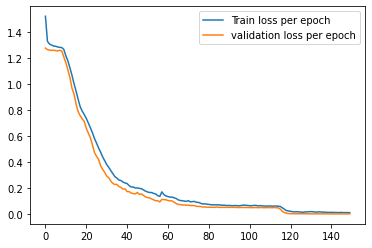

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
def display_loss_plot_seq2seq():
  train_losses = [l for l in train_losses ]
  dev_losses = [l for l in dev_losses ]
  plt.figure()
  plt.plot(train_losses[:])
  plt.plot(dev_losses[:])

  plt.legend(['Train loss per epoch', 'validation loss per epoch'])

In [0]:
# display_loss_plot_seq2seq()
if os.path.isfile('seq2seq.pt'):
  print("no training done")
else:
  display_loss_plot_seq2seq()

In [0]:
encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size=128, z_type=1)
decoder = Decoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size=128)

state = torch.load('seq2seq.pt')
encoder.load_state_dict(state['encoder'])
decoder.load_state_dict(state['decoder'])

predictions = predict(encoder, decoder, valid_x, tgt_vocab.itos)
groundtruth = [''.join(t) for t in valid_out]



['ajmuv', 'cenp', 'aeijknx', 'achnoqtw', 'ehjknoz', 'abeimpt', 'dfirswy', 'chkmruwz', 'csx', 'cdelou', 'afghiklr', 'bcgilotuz', 'efilrtvx', 'ahlpry', 'acilqrvz', 'ckpqz', 'afs', 'ekoptw', 'ioy', 'fnuxy', 'dkmuy', 'jkr', 'abcinosu', 'bcgknyz', 'cjlmpqt', 'bcgiklwz', 'cdjptuz', 'aijmnqrux', 'ilm', 'disvxy', 'dmno', 'bgopqvwxyz', 'adfhkpswz', 'abdikmuw', 'ehw', 'cgly', 'cenot', 'aceiklpt', 'chksvwy', 'ceflvwz', 'aek', 'ahjkmry', 'cefhoquw', 'bcefg', 'abchkovy', 'boqswxy', 'dinrsuwy', 'bchnsvz', 'inqsy', 'ainouyz', 'bgpqstz', 'qrstu', 'cdjkoqsv', 'cgiopqtuz', 'tvy', 'dfimnosu', 'begkx', 'bcghkpuz', 'abdfsuvx', 'agjpx', 'fhy', 'fsv', 'bfjkmnruv', 'djmoqvxyz', 'ahiuv', 'aqx', 'ginopsux', 'ceuw', 'dinorx', 'cfpy', 'aglmoruz', 'eqw', 'cfmpqvw', 'efv', 'bftxz', 'bdijklqs', 'bgmprz', 'ahimnquv', 'cfgjkprtu', 'dhmprty', 'bfilopy', 'kruxy', 'dhjknsty', 'aehkmnsuz', 'ckmu', 'djsuwx', 'bnsuwx', 'cimrx', 'ceklpvy', 'dgiox', 'bdnprstuxz', 'cfkuz', 'adoqrstuz', 'dhpstvyz', 'ci', 'abjlnpqz', 'bfgjlnqu',

In [0]:
print('Accuracy score for prediction on validation dataset')
accuracy_score(groundtruth, predictions)

Accuracy score for prediction on validation dataset


1.0

In [0]:
print('Input --> Expected output --> Prediction :')
for i in range(len(valid_inp[:20])):
    x = ''.join(valid_inp[i])
    y = ''.join(valid_out[i])
    
    print(f"+ {x} --> {y} --> {predictions[i]}")

Input --> Expected output --> Prediction :
+ jjuvvmmmauuu --> ajmuv --> ajmuv
+ ceeeppnnn --> cenp --> cenp
+ iiikkxxaaijjjnnaaeee --> aeijknx --> aeijknx
+ hqqtttnnnooawwc --> achnoqtw --> achnoqtw
+ zzooeeeooonnzkhjhhh --> ehjknoz --> ehjknoz
+ aaaepppiitmbbb --> abeimpt --> abeimpt
+ wssrriidyyyf --> dfirswy --> dfirswy
+ kkuhhcrrzzmmmwww --> chkmruwz --> chkmruwz
+ cssxx --> csx --> csx
+ ddooouulllelllc --> cdelou --> cdelou
+ lllkkkaaaggfihrrr --> afghiklr --> afghiklr
+ ttgbbiillzocccuuu --> bcgilotuz --> bcgilotuz
+ lliiieeexiivvvtttrrrfffxx --> efilrtvx --> efilrtvx
+ parhhhylll --> ahlpry --> ahlpry
+ qqqccciialrrrvvvlzzz --> acilqrvz --> acilqrvz
+ cczppkq --> ckpqz --> ckpqz
+ ffffffsaa --> afs --> afs
+ kooopppwooeet --> ekoptw --> ekoptw
+ oyyyiiio --> ioy --> ioy
+ nnnyyxxuuufff --> fnuxy --> fnuxy


# Training Seq2Seq Attention model

This model was trained and evaluated through 250 epochs to obtain the best model. The batch size was 50. And the best model was stored in seq2seq+attn.pt file.

In [0]:
if os.path.isfile('seq2seq+attn.pt'):
  print("model seq2seq+attn exists")
else:

  encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size = 128, z_type=0)
  decoder = AttentionDecoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size = 128, attn_size=64)

  best_loss = None
  attn_train_losses = []
  attn_dev_losses = []
  
  epochs = 250

  for epoch in range(1, epochs+1):
    encoder, decoder, attn_train_loss = train(encoder, decoder, train_x, train_y, epoch, batch_size = 50, print_every=1)
    attn_train_losses.append(attn_train_loss)
    # encoder, decoder = train_batch(encoder, decoder, train_x, train_y, 50, epochs= 2, print_every=1)
    encoder, decoder, attn_dev_loss = evaluate(encoder, decoder, valid_x, valid_y, epoch, batch_size=50, print_every=1)
    attn_dev_losses.append(attn_dev_loss)
    best_loss = track_best_model('seq2seq+attn.pt', encoder, decoder, epoch, best_loss, attn_dev_loss)


[TRAIN]Epoch 1 - Loss: 1.616893
[EVAL]Epoch 1 - Loss: 1.025953*
[TRAIN]Epoch 2 - Loss: 1.004439
[EVAL]Epoch 2 - Loss: 0.787039*
[TRAIN]Epoch 3 - Loss: 0.819220
[EVAL]Epoch 3 - Loss: 0.702821*
[TRAIN]Epoch 4 - Loss: 0.679648
[EVAL]Epoch 4 - Loss: 0.550586*
[TRAIN]Epoch 5 - Loss: 0.579996
[EVAL]Epoch 5 - Loss: 0.427604*
[TRAIN]Epoch 6 - Loss: 0.489426
[EVAL]Epoch 6 - Loss: 0.346895*
[TRAIN]Epoch 7 - Loss: 0.429943
[EVAL]Epoch 7 - Loss: 0.302995*
[TRAIN]Epoch 8 - Loss: 0.378330
[EVAL]Epoch 8 - Loss: 0.328911
[TRAIN]Epoch 9 - Loss: 0.330898
[EVAL]Epoch 9 - Loss: 0.241363*
[TRAIN]Epoch 10 - Loss: 0.294317
[EVAL]Epoch 10 - Loss: 0.205571*
[TRAIN]Epoch 11 - Loss: 0.259738
[EVAL]Epoch 11 - Loss: 0.180345*
[TRAIN]Epoch 12 - Loss: 0.238087
[EVAL]Epoch 12 - Loss: 0.171541*
[TRAIN]Epoch 13 - Loss: 0.235868
[EVAL]Epoch 13 - Loss: 0.210506
[TRAIN]Epoch 14 - Loss: 0.215353
[EVAL]Epoch 14 - Loss: 0.154505*
[TRAIN]Epoch 15 - Loss: 0.202673
[EVAL]Epoch 15 - Loss: 0.178389
[TRAIN]Epoch 16 - Loss: 0.17998

# Plotting losses in Seq2seq attention model

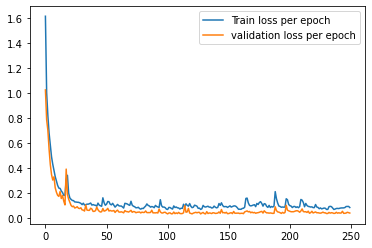

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def display_loss_plot_seq2seq_attn():
  train_losses = [l for l in attn_train_losses ]
  dev_losses = [l for l in attn_dev_losses ]
  plt.figure()
  plt.plot(train_losses[:])
  plt.plot(dev_losses[:])

  plt.legend(['Train loss per epoch', 'validation loss per epoch'])

In [0]:
# display_loss_plot_seq2seq_attn()
if os.path.isfile('seq2seq+attn.pt'):
  print("no training done")
else:
  display_loss_plot_seq2seq_attn()

In [0]:
encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size = 128, z_type=0)
decoder = AttentionDecoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size = 128, attn_size=64)

state = torch.load('seq2seq+attn.pt')
encoder.load_state_dict(state['encoder'])
decoder.load_state_dict(state['decoder'])

predictions = predict(encoder, decoder, valid_x, tgt_vocab.itos)
groundtruth = [''.join(t) for t in valid_out]
print("Accuracy score for prediction on validation dataset:")
accuracy_score(groundtruth, predictions)


['ajmuv', 'cenp', 'aeijjknx', 'achnoqttaaccnnn', 'ehhjnnnnnnkkkjh', 'abeimaaabeabeab', 'dfirswy', 'chkmurchhhcchcc', 'csx', 'cdelou', 'afghiklr', 'bcgilotuz', 'eeilrtt', 'ahlpry', 'acilqrvzz', 'ckpqz', 'afs', 'ekoptw', 'ioy', 'fnuxy', 'dkmuy', 'jkr', 'abcinosu', 'bcgknyz', 'cjlmpqt', 'bcgiklwz', 'cdjptuz', 'aiimnqruv', 'ilm', 'disvxy', 'dmno', 'bgopqvwxyy', 'adffhaaddfhkkaa', 'abdikmuuu', 'ehw', 'cgly', 'cenot', 'aceiiieeeeeeeee', 'chksvvwwchhschh', 'ceflvwz', 'aek', 'ahhjkmaajjjkjhh', 'cefhoquw', 'bcefg', 'abchkkoyaaabbck', 'boqswxy', 'dinrsuwy', 'bchnsvz', 'inqsy', 'ainouyy', 'bgpqstz', 'qrstu', 'cdjkoqsv', 'cgiopqtu', 'tvy', 'dfimnosu', 'begkx', 'bcghkpuz', 'abdfsuvx', 'agjpx', 'fhy', 'fsv', 'bfjkmnruv', 'djmoqxyyz', 'ahiuuaaiiiuuvua', 'aqx', 'ginopsux', 'ceuw', 'dinorx', 'cfpy', 'aglmorzz', 'eqw', 'cfmpqvw', 'efv', 'bftxz', 'bdijklqs', 'bgmprz', 'ahhamaaaiiimaaa', 'cfgjkprtt', 'dhmprtdhhddhhmd', 'bfilopy', 'kruxy', 'dhhjknnstdhhddd', 'aeekkaaaeaeaeae', 'ckmu', 'djsuwx', 'bnsuwx', '

0.712

In [0]:
print('Input --> Expected output --> Prediction')
for i in range(len(valid_inp[:20])):
    x = ''.join(valid_inp[i])
    y = ''.join(valid_out[i])
    
    print(f"+ {x} --> {y} --> {predictions[i]}")

Input --> Expected output --> Prediction
+ jjuvvmmmauuu --> ajmuv --> ajmuv
+ ceeeppnnn --> cenp --> cenp
+ iiikkxxaaijjjnnaaeee --> aeijknx --> aeijjknx
+ hqqtttnnnooawwc --> achnoqtw --> achnoqttaaccnnn
+ zzooeeeooonnzkhjhhh --> ehjknoz --> ehhjnnnnnnkkkjh
+ aaaepppiitmbbb --> abeimpt --> abeimaaabeabeab
+ wssrriidyyyf --> dfirswy --> dfirswy
+ kkuhhcrrzzmmmwww --> chkmruwz --> chkmurchhhcchcc
+ cssxx --> csx --> csx
+ ddooouulllelllc --> cdelou --> cdelou
+ lllkkkaaaggfihrrr --> afghiklr --> afghiklr
+ ttgbbiillzocccuuu --> bcgilotuz --> bcgilotuz
+ lliiieeexiivvvtttrrrfffxx --> efilrtvx --> eeilrtt
+ parhhhylll --> ahlpry --> ahlpry
+ qqqccciialrrrvvvlzzz --> acilqrvz --> acilqrvzz
+ cczppkq --> ckpqz --> ckpqz
+ ffffffsaa --> afs --> afs
+ kooopppwooeet --> ekoptw --> ekoptw
+ oyyyiiio --> ioy --> ioy
+ nnnyyxxuuufff --> fnuxy --> fnuxy


# Test data predictions

In [0]:
import pandas as pd

test_data = pd.read_csv('test.txt', delimiter='\t', header=None, usecols=[0,1])
test_inp, test_out = test_data[0], test_data[1]

test_inp[0], test_out[0]

('wwwttttjjjhhddmmmmqqffmmmdddcffu', 'cdfhjmqtuw')

In [0]:

MAX_INPUT_LENGTH  = find_seq_len(test_inp)
print('Maximum test input string length')
print(MAX_INPUT_LENGTH )
test_x = map_many_elems(test_inp, src_vocab.stoi, src_vocab.stoi['<pad>'],MAX_INPUT_LENGTH )

MAX_OUTPUT_LENGTH  = find_seq_len(test_out)
print('Maximun test output string length')
print(MAX_OUTPUT_LENGTH )
test_y = map_many_elems(test_out, tgt_vocab.stoi, tgt_vocab.stoi['<stop>'], MAX_OUTPUT_LENGTH)


Maximum test input string length
58
Maximun test output string length
13


# Prediction using Vanilla Seq2seq model

In [0]:
encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size=128, z_type=1)
decoder = Decoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size=128)

state_dict = torch.load('seq2seq.pt')
encoder.load_state_dict(state_dict['encoder'])
decoder.load_state_dict(state_dict['decoder'])

predictions = predict(encoder, decoder, test_x, tgt_vocab.itos)
groundtruth = [''.join(t) for t in test_out]
print('Accuracy score for vanilla seq2seq model prediction on test datat')
accuracy_score(groundtruth, predictions)

['cdfhjmqtuw', 'chmruvw', 'aehiklmrwxyz', 'hmprz', 'dgijmnoy', 'abflrsty', 'bjouy', 'clnqrsxz', 'ehptxz', 'fgv', 'ijkr', 'aegjpqsu', 'cly', 'cefmpqrw', 'ailmyz', 'cdfgklpqu', 'apqwyz', 'bcfhirz', 'clmopquw', 'cgrvy', 'elq', 'ekwx', 'aclqvwxy', 'cdfovyz', 'dfhpt', 'eghijnoqw', 'gmow', 'gny', 'aghirv', 'gnqrvz', 'cdghjqrsz', 'bklnopx', 'cfhjknoprt', 'fijkprwxz', 'adijly', 'cijkmprx', 'bghnquvw', 'cdejnquv', 'acgjpt', 'abcelmst', 'cdegkno', 'dkmprsu', 'dekoqtuxy', 'djknpqruv', 'aklmptz', 'cfgjmnruvw', 'abdejrtvxy', 'abcfijk', 'adfhptuvx', 'dghwxy', 'agho', 'elopqrz', 'aegiloqs', 'ahlw', 'akmops', 'acdglorstvy', 'aijprwz', 'anv', 'dfkmpsuvxz', 'girtuwxz', 'cgjlmv', 'abilmqstx', 'achijqtu', 'bdhmxz', 'klq', 'eiloprtvw', 'cdeq', 'bfilmx', 'bhikmnostxz', 'bhijlmqtuv', 'hknw', 'alorw', 'djkmqr', 'lqsxyz', 'djtvy', 'dejqrx', 'cdekopq', 'deijnpqtuy', 'ceijotu', 'afhz', 'cgosv', 'lmp', 'bfh', 'pvxy', 'rtz', 'abghlnpuvz', 'cjpqtvy', 'ilmnopvy', 'bfmprtx', 'acghimnqw', 'fprty', 'dgjoqvwx', 'ijmz', 

0.999

In [0]:
print('Input --> Expected output --> Prediction')
for i in range(len(test_inp[:20])):
    x = ''.join(test_inp[i])
    y = ''.join(test_out[i])
    
    print(f"+ {x} --> {y} --> {predictions[i]}")

Input --> Expected output --> Prediction
+ wwwttttjjjhhddmmmmqqffmmmdddcffu --> cdfhjmqtuw --> cdfhjmqtuw
+ cccrrrvvuhwwwwwrmmm --> chmruvw --> chmruvw
+ rzzzzxxxxxlyyyyykkmmmmaaaaaeeeeaahhhwwwwwiiii --> aehiklmrwxyz --> aehiklmrwxyz
+ rrrzzpppmmmhhhh --> hmprz --> hmprz
+ iiiidggggdddddmmjoonnnnnjjjy --> dgijmnoy --> dgijmnoy
+ ffflllllrrrsssyybttttaa --> abflrsty --> abflrsty
+ oooooooojjjjjubbbbbyyy --> bjouy --> bjouy
+ cnnrrrrrlllllzqnncccrrrrrxxsssssqqqqq --> clnqrsxz --> clnqrsxz
+ ppppteeeehhzzzxx --> ehptxz --> ehptxz
+ fvvvvvvvggggg --> fgv --> fgv
+ iiijjkkkrrrr --> ijkr --> ijkr
+ uuuuujjpppppqqqqqgggggeeeeeeaasss --> aegjpqsu --> aegjpqsu
+ llyyccccc --> cly --> cly
+ cceewppperrrqqmmf --> cefmpqrw --> cefmpqrw
+ mmiiiayyyyyzzzlllllmmm --> ailmyz --> ailmyz
+ qqqfffkklllldddddggguuukkkkkcppp --> cdfgklpqu --> cdfgklpqu
+ yyyyyqwwwwwazyyyyyppppz --> apqwyz --> apqwyz
+ ffffbbbbfffffzzzzzrriiccccchrrrrr --> bcfhirz --> bcfhirz
+ ppwwwwwwwqqqlllllmmmmcccccccccooouuu --> clmop

In [0]:
from statistics import mean 

wrong_prediction_word_len = []
correct_prediction_word_len = []
for i in range(len(predictions)):
  if(predictions[i] == groundtruth[i]):
    correct_prediction_word_len.append(len(test_inp[i]))
  else:
    wrong_prediction_word_len.append(len(test_inp[i]))

avg_correct_pred_len = mean(correct_prediction_word_len)

avg_wrong_pred_len = mean(wrong_prediction_word_len)
print('average length of correctly predicted inputs')
print(avg_correct_pred_len)
print('average length of wrongly predicted inputs')
print(avg_wrong_pred_len)


average length of correctly predicted inputs
23.797197197197196
average length of wrongly predicted inputs
24


# Prediction using Seq2seq model with attention

In [0]:
encoder = Encoder(vocab_size=len(src_vocab), emb_dim=64, lstm_size = 128, z_type=0)
decoder = AttentionDecoder(vocab_size=len(tgt_vocab), emb_dim=64, lstm_size =128, attn_size=64)

state_dict = torch.load('seq2seq+attn.pt')
encoder.load_state_dict(state_dict['encoder'])
decoder.load_state_dict(state_dict['decoder'])

predictions = predict(encoder, decoder, test_x, tgt_vocab.itos)
groundtruth = [''.join(t) for t in test_out]
print('Accuracy score for seq2seq attention model prediction on test data')
accuracy_score(groundtruth, predictions)

['cdfhjmqqtuw', 'chmruvw', 'aeehaaaeaeaeaee', 'hmmpmppprzzpppp', 'dgijmnoy', 'abflraaaafaaaaa', 'bjouy', 'clnqqrxz', 'ehppxx', 'fgv', 'ijkr', 'aeggjpsuuaaaaeg', 'cly', 'cefmpqrw', 'ailmzz', 'cdfgklpqu', 'apqwyyz', 'bcfhir', 'clmopquw', 'cgrvy', 'elq', 'ekwx', 'aclqvwxyy', 'cdfovyz', 'dfhpt', 'eggijnoqw', 'gmow', 'gny', 'aggirv', 'gnqqrzz', 'cdggjqrsz', 'bklnopx', 'cfhkkooptt', 'fijkprwxz', 'adijly', 'cijkmprx', 'bghnquvw', 'cdejnquv', 'acgjpt', 'abcelmaaaabcelm', 'cdegkno', 'dkmprsu', 'dekoqqttdeekkke', 'djknpqruv', 'aklmptz', 'cfgjmnruvx', 'abdejrtxyy', 'abcfijk', 'adfhhaadfhaadfa', 'dghwxy', 'agho', 'elopqqz', 'aeggiloqaaaeggi', 'ahhawaaaallw', 'akmoos', 'acdglortty', 'aijprwzz', 'anv', 'dfkmpsuvxz', 'girtuwxz', 'cgjlmv', 'abilmqstx', 'achijqtu', 'bdhmxz', 'klq', 'eiloprtvw', 'cdeq', 'bfilmx', 'bhhkknnnstx', 'bhijlmqqiijjiij', 'hknnw', 'alorw', 'djkmqr', 'lqsxyz', 'djtvy', 'dejqqxx', 'cdekopqq', 'deijnpqtuy', 'ceejjou', 'afhzz', 'cgosv', 'lmp', 'bfh', 'pvxy', 'rtz', 'abghlnpuvz', 'cj

0.6004

In [0]:
print('Input --> Expected output --> Prediction')
for i in range(len(test_inp[:20])):
    x = ''.join(test_inp[i])
    y = ''.join(test_out[i])
    
    print(f"+ {x} --> {y} --> {predictions[i]}")

Input --> Expected output --> Prediction
+ wwwttttjjjhhddmmmmqqffmmmdddcffu --> cdfhjmqtuw --> cdfhjmqqtuw
+ cccrrrvvuhwwwwwrmmm --> chmruvw --> chmruvw
+ rzzzzxxxxxlyyyyykkmmmmaaaaaeeeeaahhhwwwwwiiii --> aehiklmrwxyz --> aeehaaaeaeaeaee
+ rrrzzpppmmmhhhh --> hmprz --> hmmpmppprzzpppp
+ iiiidggggdddddmmjoonnnnnjjjy --> dgijmnoy --> dgijmnoy
+ ffflllllrrrsssyybttttaa --> abflrsty --> abflraaaafaaaaa
+ oooooooojjjjjubbbbbyyy --> bjouy --> bjouy
+ cnnrrrrrlllllzqnncccrrrrrxxsssssqqqqq --> clnqrsxz --> clnqqrxz
+ ppppteeeehhzzzxx --> ehptxz --> ehppxx
+ fvvvvvvvggggg --> fgv --> fgv
+ iiijjkkkrrrr --> ijkr --> ijkr
+ uuuuujjpppppqqqqqgggggeeeeeeaasss --> aegjpqsu --> aeggjpsuuaaaaeg
+ llyyccccc --> cly --> cly
+ cceewppperrrqqmmf --> cefmpqrw --> cefmpqrw
+ mmiiiayyyyyzzzlllllmmm --> ailmyz --> ailmzz
+ qqqfffkklllldddddggguuukkkkkcppp --> cdfgklpqu --> cdfgklpqu
+ yyyyyqwwwwwazyyyyyppppz --> apqwyz --> apqwyyz
+ ffffbbbbfffffzzzzzrriiccccchrrrrr --> bcfhirz --> bcfhir
+ ppwwwwwwwqqqlllllm

In [0]:
attn_wrong_prediction_word_len = []
attn_correct_prediction_word_len = []

for i in range(len(predictions)):
  if(predictions[i] == groundtruth[i]):
    attn_correct_prediction_word_len.append(len(test_inp[i]))
  else:
    attn_wrong_prediction_word_len.append(len(test_inp[i]))


avg_correct_pred_len = mean(attn_correct_prediction_word_len)

avg_wrong_pred_len = mean(attn_wrong_prediction_word_len)
print('average length of correctly predicted inputs')
print(avg_correct_pred_len)
print('average length of wrongly predicted inputs')
print(avg_wrong_pred_len)

average length of correctly predicted inputs
20.07728181212525
average length of wrongly predicted inputs
29.386886886886888


# Analysis

The vanilla seq2seq model which was trained over 150 epochs performs better than the model with attention in the decoder. 

Accuracy of vanilla seq2seq model on testdata : 99.9%
Accuracy of seq2seq model with attention on testdata : 60%

The model with attention took around 250 epochs to attain the so far best accuracy. But after 250th epoch the loss in training and validation increased at a rapid rate. And also yielded low performance in the test data prediction. So the epochs was kept at 250 for the model with attention.

The reason why the model with attention performs lower could be due to the processing of the strings and the parameters in the model architecture. In the future, this model could be improved in performance by tuning the parameteres. 

Another observation was the evaluation loss lesser than the training loss which is explained in the losses plot section.

One more observation here is the length of the strings in the datasets. 
<ul>
<li> The Maximun input length of the training and validation sets is 28. 
<li>And we can see the model with attention has got wrong predictions in strings of average length 29. 
<li>The performance of the model could be improved if the training datsets have inputs strings of length equal to the test dataset
</ul>